In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Problem 1

In [2]:
data = pd.read_table('data/irs.txt')
data = np.array(data).flatten()
data.shape

(30,)

In [3]:
N = data.shape[0]
B = 1000
sample_medians = []
for i in range(B):
    bootstrap = np.random.choice(data, N, replace=True)
    sample_medians.append(np.median(bootstrap))

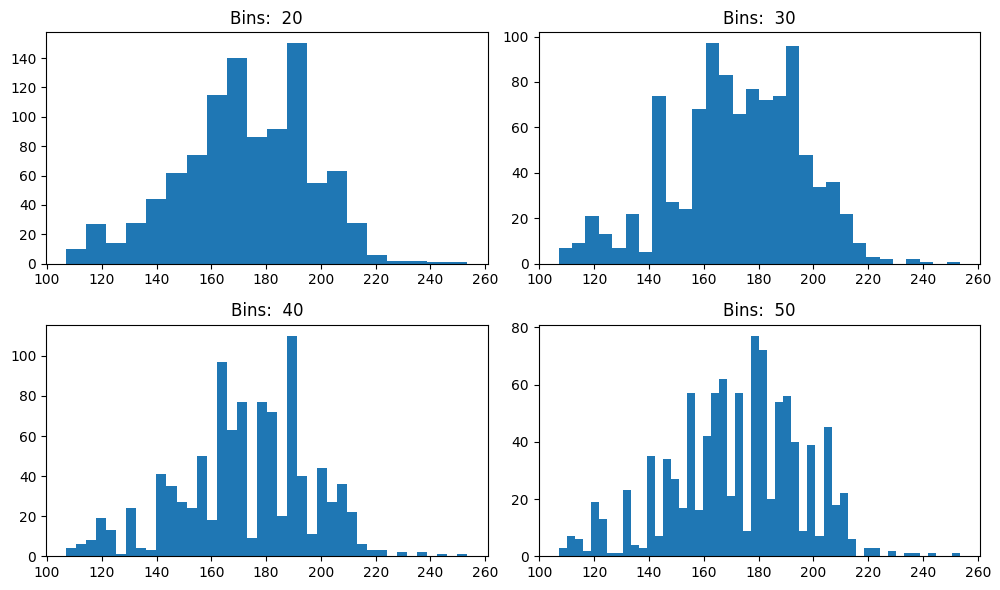

In [4]:
bins = np.linspace(20, 50, 4)
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
for i, ax in enumerate(axs.flatten()):
    ax.hist(sample_medians, bins=int(bins[i]))
    ax.set_title(f'Bins: {bins[i]: .0f}')
plt.tight_layout()

In [5]:
left_ci = np.percentile(sample_medians, 2.5)
right_ci = np.percentile(sample_medians, 97.5)
print(f'95% CI: ({left_ci}, {right_ci})')

95% CI: (119.0, 212.0)


### Problem 2

In [28]:
import scipy.stats as st

In [29]:
R = 1e5
alpha = 0.03
n = 80
mu1, mu2 = 0, 1
c = st.norm.ppf(1 - alpha) / np.sqrt(n)
c

np.float64(0.21027911797366494)

In [30]:
# part a)
means1 = np.array([np.random.normal(mu1, 1, n).mean() for _ in range(int(R))])
np.sum(means1 > c)

np.int64(2990)

In [31]:
# empirical FNR
print(f'Empirical FNR: {np.sum(means1 > c) / R}')
# theoretical FNR
print(f'Theoretical FNR: {alpha}')

Empirical FNR: 0.0299
Theoretical FNR: 0.03


In [32]:
# part b)
means2 = np.array([np.random.normal(mu2, 1, n).mean() for _ in range(int(R))])
np.sum(means2 > c)

np.int64(100000)

In [33]:
# empircal power (TNR)
print(f'Empirical Power: {np.sum(means2 > c) / R}')
# theoretical power (TNR)
print(f'Theoretical Power: {1 - st.norm.cdf(c - np.sqrt(n))}')

Empirical Power: 1.0
Theoretical Power: 1.0


### Problem 3

In [10]:
n = 4
lambda0, lambda1 = 1, 4
c = st.gamma.ppf(0.02, a=n, scale=1 / lambda0)
c

np.float64(1.0162384590409617)

In [11]:
beta = 1 - st.gamma.cdf(c, a=n, scale=1 / lambda1)
beta

np.float64(0.42088441180299785)

In [12]:
data = np.array([1.2, 3, 1.5, 0.3])
obs = data.sum()
pval = st.gamma.cdf(obs, a=n, scale=1 / lambda0)
pval

np.float64(0.8487961172233521)

### Problem 4

In [13]:
n = 63
mean = 16.7
s = 3.3

In [14]:
# CI for mean
alpha = 0.05
left_ci = mean - st.t.ppf(1 - alpha / 2, n - 1) * s / np.sqrt(n)
right_ci = mean + st.t.ppf(1 - alpha / 2, n - 1) * s / np.sqrt(n)
print(f'CI: ({left_ci:.2f}, {right_ci:.2f})')

CI: (15.87, 17.53)


In [15]:
# CI for variance
alpha = 0.06
left_ci = (n - 1) * s ** 2 / st.chi2.ppf(1 - alpha / 2, n - 1)
right_ci = (n - 1) * s ** 2 / st.chi2.ppf(alpha / 2, n - 1)
print(f'CI: ({left_ci:.2f}, {right_ci:.2f})')

CI: (7.98, 15.77)


### Problem 5

In [16]:
# Beta MLE
from scipy.stats import beta
from scipy.optimize import minimize
x = np.array([0.34, 0.47, 0.42, 0.23, 0.26])
# x = np.random.beta(2, 5, 1000)

def nll_beta(params):
    a, b = params
    return -np.sum(beta.logpdf(x, a, b))

result = minimize(nll_beta, x0=[1, 1])
a_mle, b_mle = result.x
print(f'MLE: a={a_mle:.2f}, b={b_mle:.2f}')

MLE: a=9.21, b=17.57


In [21]:
# Wald CI for alpha and beta
fisher_inv = result.hess_inv
fisher = np.linalg.inv(fisher_inv)

In [18]:
alpha = 0.05
est_se = np.sqrt(np.diag(fisher_inv))
theta = np.array([a_mle, b_mle])
z = st.norm.ppf(1 - alpha / 2)
left_ci = theta - z * est_se
right_ci = theta + z * est_se
print(f"alpha CI: ({left_ci[0]:.2f}, {right_ci[0]:.2f})")
print(f"beta CI: ({left_ci[1]:.2f}, {right_ci[1]:.2f})")

alpha CI: (-1.94, 20.37)
beta CI: (-3.88, 39.02)


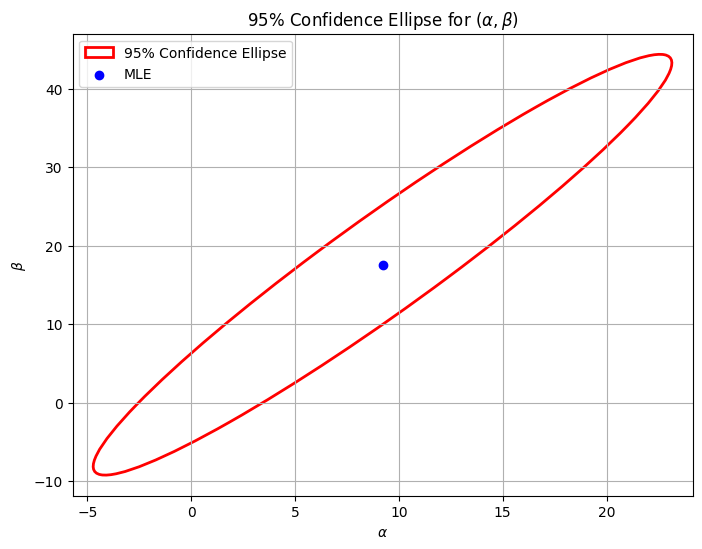

In [20]:
from matplotlib.patches import Ellipse

center = np.array([a_mle, b_mle])
cov_mat = fisher_inv

# 95% confidence level: chi-square quantile with 2 degrees of freedom
chi2_val = st.chi2.ppf(0.95, 2)

# Eigen-decomposition of the covariance matrix to determine ellipse parameters
vals, vecs = np.linalg.eigh(cov_mat)
# Sort eigenvalues in descending order
order = vals.argsort()[::-1]
vals = vals[order]
vecs = vecs[:, order]

# The lengths of the semi-axes of the ellipse:
# (multiply by sqrt(chi2_val) to get the 95% confidence region)
width = 2 * np.sqrt(vals[0] * chi2_val)   # full length of major axis
height = 2 * np.sqrt(vals[1] * chi2_val)  # full length of minor axis

# Calculate the angle of rotation (in degrees) from the eigenvectors
angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

# Create an ellipse patch with the computed parameters
ellipse_patch = Ellipse(xy=center, width=width, height=height,
                          angle=angle, edgecolor='red', fc='None',
                          lw=2, label='95% Confidence Ellipse')

# Plotting the ellipse along with the MLE point
fig, ax = plt.subplots(figsize=(8, 6))
ax.add_patch(ellipse_patch)
ax.scatter(center[0], center[1], color='blue', label='MLE')

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('95% Confidence Ellipse for $(\\alpha, \\beta)$')
ax.legend()

# # Adjust plot limits for clarity
# ax.set_xlim(center[0] - width, center[0] + width)
# ax.set_ylim(center[1] - height, center[1] + height)
ax.grid(True)

plt.show()